# Load musiccaps

In [1]:
from musiccaps import load_musiccaps
import numpy as np

In [2]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True
)
embeddings = np.load('embeddings.npy', allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


# Image captioning

In [3]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchinfo
import torch.nn as nn
from tqdm.auto import tqdm
import itertools

In [9]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").cuda()
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

encoder_forward = model.encoder.forward

In [10]:
def create_batcher(bs):
    for epoch in itertools.count(0, 1):
        captions, embs = [], []
        
        for i in np.random.permutation(len(ds)):
            i = int(i)
            try:
                cap = ds[i]['caption']
                emb = embeddings[ds[i]['ytid']]
            except Exception as e:
                continue
                
            captions.append(cap)
            embs.append(emb)
            
            if len(captions) == bs:
                assert len(embs) == bs
                captions_tok = tokenizer(captions, padding='longest', return_tensors='pt')['input_ids'].cuda()
                embs = torch.from_numpy(np.stack(embs)).cuda()
                yield captions, captions_tok, embs, epoch
                captions, embs = [], []

In [11]:
class B2T(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(512, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 768)
        )
        
    def forward(self, x):
        return self.main(x)
    
b2t = B2T().cuda()
opt = torch.optim.Adam([*b2t.parameters()], lr=0.0001) # , *model.decoder.parameters()]

opt = torch.optim.Adam([
    {'params': b2t.parameters(), 'lr': 0.0001},
    {'params': model.parameters(), 'lr': 0.000005}
])

losses = []
bs = 32
fake_pixel_values = torch.zeros((bs, 3, 224, 224)).cuda()
batcher = create_batcher(bs)
patch_enabled = False

In [12]:
def patched_forward(*args, **kwargs):
    result = encoder_forward(*args, **kwargs)
    if not patch_enabled:
        result.last_hidden_state = b2t(embs[0:1]).unsqueeze(1).repeat(1, 197, 1)
    else:
        result.last_hidden_state = b2t(embs).unsqueeze(1).repeat(1, 197, 1)
        # torch.randn_like(result.last_hidden_state)*0.3
    return result

model.encoder.forward = patched_forward

0it [00:00, ?it/s]

a man is standing in front of a wooden table
The low quality recording features an acoustic rhythm guitar and flat female vocal singing on top of it. There is a lot of reverb on vocals, which makes it sound too separate from the guitar. The guitar, in the second half of the loop, is played a bit sloppy.



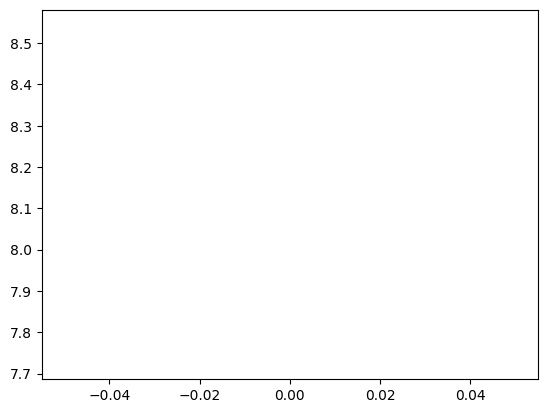

a drum set with a guitar and drums on it
A low sounding male voice is rapping over a fast paced drums playing a reggaeton beat along with a bass. Something like a guitar is playing the melody along. This recording is of poor audio-quality. In the background a laughter can be noticed. This song may be playing in a bar.

a beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up beat up
The low quality recording features a, what it seems like, cover of a country song and it consists of flat male vocals singing over acoustic sitar guitar melody. It sounds ve

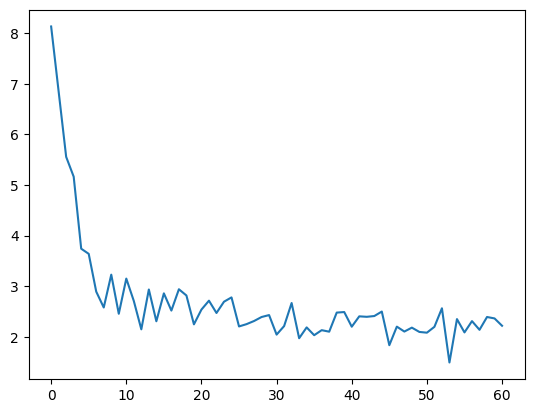

the music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the speakers in the room. The music is playing on the
The song is mostly instrumental with a faint male vocal. The song is medium tempo with a slick drumming rhythm , booming bass line, siren tones and a keyboard playing  arpeggiated tones. The song is followed by camera flash and click tones. The song is exciting with a lot of fanfare. The song is fading with the end credits superimposed with camera flash tones.

a male in a white shirt is playing a music video game. He 

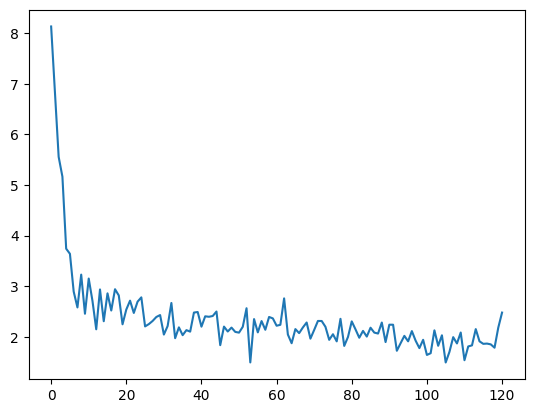

a male voice is playing a song that is in the middle of a drum beat. The song is in the middle of a drum beat. The song is in the middle of a drum beat. The song is in the middle of a drum beat. The song is in the middle of a drum beat. The song is in the middle of a drum beat. The song is in the middle of a drum beat. The song is in the middle of a drum beat. The song is in the middle of a drum beat. The song is in the middle of a drum beat. The song is in the middle of a drum beat.
This is a live recording of an italian song that is primarily played on the accordions. We have a male vocalist with a mature voice, who sings in a tone that feels a little bit sombre. The music itself has a romantic feeling to it.



In [ ]:
for step in tqdm(itertools.count(0, 1)):
    captions, captions_tok, embs, epoch = next(batcher)

    patch_enabled = True
    loss = model(fake_pixel_values, labels=captions_tok).loss
    patch_enabled = False
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    
    if step % 20 == 0:
        output_ids = model.generate(fake_pixel_values[0:1], max_length=128, num_beams=2)
        print(tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip())
        print(captions[0])
        print()
    
    if step % 60 == 0:
        plt.plot(losses)
        plt.show()

In [7]:
def patched_forward(*args, **kwargs):
    for arg in args:
        if not arg is None:
            print(type(arg))
    for k, v in kwargs.items():
        if not v is None:
            print(k, type(v))
    print('---- RETURN VAL ---')
    result = f(*args, **kwargs)
    print(type(result))
    for k in result:
        print(k, getattr(result, k).shape)
    print('\n'*3)
    result.last_hidden_state[:] = torch.randn_like(result.last_hidden_state)*0.3
    return result

model.encoder.forward = patched_forward

In [156]:
f??

Signature:
f(
    pixel_values: Optional[torch.Tensor] = None,
    bool_masked_pos: Optional[torch.BoolTensor] = None,
    head_mask: Optional[torch.Tensor] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    interpolate_pos_encoding: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple, transformers.modeling_outputs.BaseModelOutputWithPooling]
Docstring:
The [`ViTModel`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care of running the pre and post processing steps while
the latter silently ignores them.

</Tip>

Args:
    pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
        Pixel values. Pixel values can be obtained using [`AutoImageProcessor`]. See [`ViTImageProcessor.__call

In [251]:
model.forward??

Signature:
model.forward(
    pixel_values: Optional[torch.FloatTensor] = None,
    decoder_input_ids: Optional[torch.LongTensor] = None,
    decoder_attention_mask: Optional[torch.BoolTensor] = None,
    encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
    past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
    decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    **kwargs,
) -> Union[Tuple[torch.FloatTensor], transformers.modeling_outputs.Seq2SeqLMOutput]
Docstring:
The [`VisionEncoderDecoderModel`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care

In [250]:
model(pixel_values, labels=output_ids)

<class 'torch.Tensor'>
return_dict <class 'bool'>
---- RETURN VAL ---
<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
last_hidden_state torch.Size([1, 197, 768])
pooler_output torch.Size([1, 768])






Seq2SeqLMOutput(loss=tensor(2.3366, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[[ -35.8679,  -26.7638,  -27.6791,  ...,  -47.7585,  -43.8306,
           -32.5497],
         [ -42.1690,  -32.1792,  -33.5180,  ...,  -53.5255,  -48.5961,
           -37.6655],
         [ -32.6727,  -30.1231,  -34.8829,  ...,  -42.8414,  -30.4824,
           -30.9890],
         ...,
         [ -46.9919,  -44.8377,  -49.4250,  ...,  -55.7228,  -49.0115,
           -45.0781],
         [ -62.6528,  -61.6987,  -66.5732,  ...,  -79.3381,  -68.3395,
           -59.0497],
         [-125.0046, -122.8182, -127.5253,  ..., -142.7821, -135.1219,
           -94.1819]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-0.4639,  1.0217,  0.5178,  ..., -1.3494,  0.0604,  0.9517],
          [-0.8643,  0.9492,  1.7128,  ..., -1.6513, -0.4688,  1.2078],
          [-1.5492,  2.0069,  1.2288,  ..., -0.7368, -1.7374,  1.7684],
          ...,
          [-2.2556,  2.2525,  1.3288,  

In [239]:
output_ids = model.generate(pixel_values, **gen_kwargs)
tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

output_attentions <class 'bool'>
output_hidden_states <class 'bool'>
return_dict <class 'bool'>
pixel_values <class 'torch.Tensor'>
---- RETURN VAL ---
<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
last_hidden_state torch.Size([1, 197, 768])
pooler_output torch.Size([1, 768])






'a person standing next to a pile of luggage'

In [111]:
handle.remove()
def hook(m, input, output):
    print(type(m))
    print('Input shapes', type(input), len(input))
    
    if isinstance(input, tuple):
        for x in input:
            print(type(x))
    print('Output shapes')
    
    print(type(output))
    
    
    print(output.shape)

handle = model.decoder.register_forward_hook(hook)

In [119]:

image_path = 'croissant.jpg'
image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert(mode="RGB")
pixel_values = feature_extractor(images=[image], return_tensors="pt").pixel_values.to(device)